In [1]:
import os
import sys
sys.path.append('/home/cocoza4/workspace/absorouteio/asr-face-recognition/src')
import math
import time
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.applications import resnet50, densenet
from PIL import Image
import matplotlib.pyplot as plt

import lfw
import losses
from models import NormDense

tf.__version__

'2.1.0'

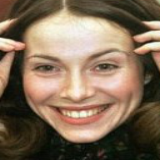

In [2]:
path = '/home/cocoza4/datasets/lfw_mtcnnpy_160/Yekaterina_Guseva/Yekaterina_Guseva_0001.png'
img = Image.open(path)
img

In [3]:
np_img = np.asarray(img)

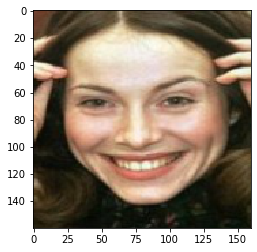

In [4]:
plt.imshow(tf.image.random_flip_left_right(np_img))

In [5]:
img_tensor = tf.constant(np.asarray(img), dtype=tf.float32)
img_tensor.shape

TensorShape([160, 160, 3])

In [6]:
from tensorflow.keras.applications import densenet

In [7]:
img_tensor2 = tf.constant(np.asarray(img), dtype=tf.float32)

In [12]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
def imagenet_preprocess(x):
    # image /= 255.
    # image[..., 0] -= mean[0]
    # image[..., 1] -= mean[1]
    # image[..., 2] -= mean[2]
    # image[..., 0] /= std[0]
    # image[..., 1] /= std[1]
    # image[..., 2] /= std[2]
    x /= 255.
    x = tf.stack([x[..., 0] - mean[0], x[..., 1] - mean[1], x[..., 2] - mean[2]], axis=-1)
    x = tf.stack([x[..., 0] / std[0], x[..., 1] / std[1], x[..., 2] / std[2]], axis=-1)
    return x

x1 = imagenet_preprocess(img_tensor)

In [13]:
x2 = densenet.preprocess_input(img_tensor)

In [16]:
np.isclose(x1, x2, atol=0.001).all()

True

In [77]:
xxx = tf.Variable([[1, 1, 1], [2, 2, 2], [3, 3, 3]])
xxx

<tf.Variable 'Variable:0' shape=(3, 3) dtype=int32, numpy=
array([[1, 1, 1],
       [2, 2, 2],
       [3, 3, 3]], dtype=int32)>

In [79]:
xxx[..., 0]

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 3], dtype=int32)>

In [73]:
tftmp = tf.stack([xxx[..., 0] - [1], xxx[..., 1] - [0], xxx[..., 2] - [2]], axis=-1)
tftmp

<tf.Tensor: shape=(3, 3, 3), dtype=float32, numpy=
array([[[ 0.,  1., -1.],
        [ 0.,  1., -1.],
        [ 0.,  1., -1.]],

       [[ 0.,  1., -1.],
        [ 0.,  1., -1.],
        [ 0.,  1., -1.]],

       [[ 0.,  1., -1.],
        [ 0.,  1., -1.],
        [ 0.,  1., -1.]]], dtype=float32)>

In [68]:
tftmp = tf.stack([img_tensor[..., 0] - mean[0], img_tensor[..., 1] - mean[1], img_tensor[..., 2] - mean[2]], axis=-1)
abc = tf.stack([tftmp[..., 0] - std[0], tftmp[..., 1] - std[1], tftmp[..., 2] - std[2]], axis=-1)
abc

<tf.Tensor: shape=(160, 160, 3), dtype=float32, numpy=
array([[[113.286    ,  66.32     ,  46.369003 ],
        [112.286    ,  65.32     ,  45.369003 ],
        [113.286    ,  65.32     ,  47.369003 ],
        ...,
        [165.286    , 156.32     , 125.369    ],
        [176.286    , 172.32     , 139.36899  ],
        [177.286    , 185.32     , 146.36899  ]],

       [[113.286    ,  65.32     ,  51.369003 ],
        [112.286    ,  65.32     ,  50.369003 ],
        [111.286    ,  64.32     ,  47.369003 ],
        ...,
        [144.286    , 130.32     , 101.369    ],
        [164.286    , 155.32     , 124.369    ],
        [168.286    , 172.32     , 135.36899  ]],

       [[109.286    ,  63.32     ,  48.369003 ],
        [109.286    ,  62.32     ,  47.369003 ],
        [109.286    ,  62.32     ,  45.369003 ],
        ...,
        [120.286    , 106.32     ,  77.369    ],
        [141.286    , 132.32     , 100.369    ],
        [157.286    , 159.32     , 122.369    ]],

       ...,

     

In [16]:
img_tensor = tf.convert_to_tensor([tf.constant(np.asarray(img)), tf.constant(np.asarray(img))])
img_tensor

<tf.Tensor: shape=(2, 160, 160, 3), dtype=uint8, numpy=
array([[[[114,  67,  47],
         [113,  66,  46],
         [114,  66,  48],
         ...,
         [166, 157, 126],
         [177, 173, 140],
         [178, 186, 147]],

        [[114,  66,  52],
         [113,  66,  51],
         [112,  65,  48],
         ...,
         [145, 131, 102],
         [165, 156, 125],
         [169, 173, 136]],

        [[110,  64,  49],
         [110,  63,  48],
         [110,  63,  46],
         ...,
         [121, 107,  78],
         [142, 133, 101],
         [158, 160, 123]],

        ...,

        [[ 31,  28,  11],
         [ 32,  29,  12],
         [ 34,  30,  13],
         ...,
         [ 12,  18,   4],
         [ 17,  22,   8],
         [ 28,  29,  15]],

        [[ 35,  32,  17],
         [ 36,  33,  17],
         [ 37,  33,  16],
         ...,
         [ 11,  16,   3],
         [ 13,  16,   3],
         [ 22,  22,  10]],

        [[ 35,  32,  17],
         [ 37,  32,  18],
         [ 37,  31

In [5]:
epochs = 2
n_classes = 16
lr = 0.0001
m1 = 1.0
m2 = 0.2
m3 = 0.3
s = 64.
img_w = 112
img_h = 112
embedding_size = 512

base_logdir = '/tmp/dir'
data_dir = '/home/cocoza4/datasets/lfw_sample'

In [6]:
initial_learning_rate =lr
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=2,
    decay_rate=0.96,
    staircase=True)

In [7]:
optimizer = tf.keras.optimizers.Adam(lr_schedule)

In [8]:
lr_schedule(10), tf.cast(128, tf.int64)

(<tf.Tensor: shape=(), dtype=float32, numpy=8.1537255e-05>,
 <tf.Tensor: shape=(), dtype=int64, numpy=128>)

In [9]:
class ArcFaceModel(tf.keras.Model):
    
    def __init__(self, backbone, n_classes):
        super().__init__()
        self.backbone = backbone
        self.norm_dense = NormDense(n_classes)

    def call(self, inputs, training=False):
        prelogits = self.backbone(inputs, training=training)

        if training:
            norm_dense = self.norm_dense(prelogits)
            return prelogits, norm_dense
        else:
            embeddings = tf.nn.l2_normalize(prelogits, axis=-1)
            return embeddings

In [40]:
backbone = tf.keras.Sequential([
    tf.keras.applications.DenseNet121(include_top=False, pooling='avg'),
    tf.keras.layers.Dense(embedding_size)
])

backbone

29089792/29084464 [==============================] - 115s 4us/step


In [48]:
tf.keras.applications.resnet_v2.ResNet101V2(include_top=False, pooling='avg')

 20332544/171317808 [==>...........................] - ETA: 10:09

KeyboardInterrupt: 

In [41]:
model = ArcFaceModel(backbone, n_classes)

In [54]:
densenet.preprocess_input(np.asarray(Image.open(lfw_paths[0]))).shape

(160, 160, 3)

In [42]:
np.array([preprocess(path, training=False).numpy() for path in lfw_paths[0:3]])

array([[[[0.5792517 , 0.55964386, 0.53611445],
         [0.4727691 , 0.45316127, 0.42765108],
         [0.4080032 , 0.39153662, 0.35780314],
         ...,
         [0.31652662, 0.24369746, 0.1807323 ],
         [0.30674267, 0.23391354, 0.17424968],
         [0.29915965, 0.2263305 , 0.16666664]],

        [[0.68533415, 0.6707683 , 0.6447179 ],
         [0.6068227 , 0.5922569 , 0.5662065 ],
         [0.5501401 , 0.5356743 , 0.5080232 ],
         ...,
         [0.31532615, 0.2511805 , 0.19095638],
         [0.31692678, 0.25278112, 0.19255704],
         [0.3145658 , 0.25042015, 0.19019605]],

        [[0.7617447 , 0.75082034, 0.7230892 ],
         [0.7032613 , 0.692337  , 0.66460586],
         [0.65634257, 0.6454182 , 0.6176671 ],
         ...,
         [0.26780716, 0.22132854, 0.16754705],
         [0.29087642, 0.23905568, 0.18825534],
         [0.30894366, 0.25460193, 0.2034014 ]],

        ...,

        [[0.09327731, 0.09327731, 0.09327731],
         [0.09019608, 0.09019608, 0.09019608]

In [71]:
@tf.function
def train_step(model, inputs, labels):
    with tf.GradientTape() as tape:
        prelogits, norm_dense = model(inputs, training=True)
        loss = losses.arcface_loss(prelogits, norm_dense, labels, m1, m2, m3, s)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

@tf.function
def test_step(model, images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    prelogits, norm_dense = model(images, training=True) # training mode as loss is calculated
    loss = losses.arcface_loss(prelogits, norm_dense, labels, m1, m2, m3, s)

    return loss

@tf.function
def predict_embedding(model, images):
    embeddings = model(images, training=False)
    return embeddings


def preprocess(path, training=True):
    raw = tf.io.read_file(path)
    image = tf.image.decode_png(raw)
    if training:
        image = tf.image.random_flip_left_right(image)
#     image = tf.cast(image, tf.float32)
    image = densenet.preprocess_input(image)
    image = tf.image.resize(image, (img_w, img_h))
    
    # image = tf.image.resize(image, (224, 224))
    # image = tf.image.random_crop(image, size=[112, 112, 3])

    # image = image[None, ...]
    return image


def get_data(path):
    ids = [o for o in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, o))]
    ids.sort()
    cat_num = len(ids)

    id_dict = dict(zip(ids, list(range(cat_num))))
    paths = []
    labels = []
    for i in ids:
        cur_dir = os.path.join(path, i)
        fns = os.listdir(cur_dir)
        paths.append([os.path.join(cur_dir, fn) for fn in fns])
        labels.append([id_dict[i]] * len(fns))

    return paths, labels

def generate(path, preprocess_fn=preprocess, batch_size=128):
    paths, labels = get_data(path)
    n_classes = len(paths)
    paths = [path for cls in paths for path in cls]
    labels = [label for cls in labels for label in cls]
    
    assert (len(paths) == len(labels))
    def p(inputs, labels): return preprocess_fn(inputs), labels
    
    ds = (tf.data.Dataset.from_tensor_slices((paths, labels))
          .cache()
          .shuffle(20000)
          .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
          .map(p, num_parallel_calls=tf.data.experimental.AUTOTUNE)
          .batch(batch_size))
    
    return ds

def evaluate(model, lfw_paths, actual_issame, batch_size, n_folds):
    n_images = len(actual_issame) * 2
    assert len(lfw_paths) == n_images

    embs_array = np.zeros((n_images, args.embedding_size))
    it = tqdm(range(0, n_images, batch_size), 'Predict embeddings')
    for start in it:
        end = start + batch_size
        preprocessed = np.array([preprocess(path, training=False) for path in lfw_paths[start:end]])
        embs_array[start:end] = predict_embedding(model, preprocessed)
        
    _, _, accuracy, val, val_std, far = lfw.evaluate(embs_array, actual_issame, n_folds=n_folds)
    
    print('Accuracy: %1.3f+-%1.3f' % (np.mean(accuracy), np.std(accuracy)))
    print('Validation rate: %2.5f+-%2.5f @ FAR=%2.5f' % (val, val_std, far))

    return np.mean(accuracy), val

In [70]:
join_path = lambda p, x: os.path.isdir(os.path.join(p, x))
[o for o in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, o))]

['Jackie_Chan',
 'Anna_Faris',
 'Ricardo_Sanchez',
 'Mahdi_Al_Bassam',
 'Madonna',
 'Alan_Greenspan',
 'Lisa_Girman',
 'Li_Peng',
 'Daniel_Darnell',
 'Emma_Thompson',
 'Igor_Ivanov',
 'Emma_Watson',
 'Annie_Chaplin',
 'Wu_Peng',
 'Clint_Eastwood',
 'Coco_dEste']

In [63]:
os.path.isdir

<function genericpath.isdir(s)>

In [44]:
current_time = datetime.now().strftime("%Y-%m-%d")
logdir = os.path.join(base_logdir, current_time)

summary = tf.compat.v2.summary
writer = summary.create_file_writer(logdir)

global_step = tf.Variable(0, name="global_step", dtype=tf.int64)

# pairs = lfw.read_pairs(args.lfw_pairs)
# lfw_paths, actual_issame = lfw.get_paths(args.lfw_dir, pairs)

train_gen = generate(data_dir, batch_size=4)

In [45]:
# preprocessed = [preprocess(path) for path in lfw_paths[0:2]]
# np.array(preprocessed).shape

In [46]:
# np.array(preprocessed).shape

In [36]:
ckpt_dir = './models'

In [37]:
ckpt = tf.train.Checkpoint(backbone=model.backbone, model=model, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_dir, max_to_keep=10, checkpoint_name='model')

In [39]:
save_path = ckpt_manager.save()
print('Saving checkpoint for epoch {} at {}'.format(epoch, save_path))

Saving checkpoint for epoch 1 at ./models/model-1


In [16]:
# summary_dir = '/tmp/logs'
# current_time = datetime.now().strftime("%Y-%m-%d")
# train_logdir = summary_dir # os.path.join(summary_dir, current_time, 'train')
# # valid_log_dir = os.path.join(summary_dir, current_time, 'valid')

# # summary_writer = tf.compat.v2.summary.create_file_writer(current_time)
# writer = tf.compat.v2.summary.create_file_writer(train_logdir)
# summary = tf.compat.v2.summary

In [17]:
steps_per_epoch = 5
epoch = 0
lfw_n_folds = 10
eval_every = 1
batch_size = 32

global_step = tf.Variable(0, name="global_step", dtype=tf.int64)

lfw_dir = '/home/cocoza4/datasets/lfw_mtcnnpy_160'
lfw_pairs = lfw_dir + '/pairs.txt'

In [18]:
train_gen = generate(data_dir, batch_size=8)

In [19]:
pairs = lfw.read_pairs(lfw_pairs)
lfw_paths, actual_issame = lfw.get_paths(lfw_dir, pairs)

In [56]:
with writer.as_default():
    for epoch in range(epochs):

        for inputs, targets in train_gen:
            t1 = time.time()
            loss = train_step(model, inputs, targets)
            elapsed = time.time() - t1
            summary.scalar('train/loss', loss, step=global_step)
            current_lr = lr_schedule(global_step)
            print('Epoch: %d\tStep: %d\tTime %.3f\tLoss %2.3f\tLearning Rate: %.5f' % 
                    (epoch+1, global_step, elapsed, loss, current_lr))

            global_step.assign_add(1)

#         if epoch % eval_every == 0 or epoch == epochs-1:
#             t1 = time.time()
#             accuracy, val = evaluate(lfw_paths, actual_issame, batch_size, lfw_n_folds)
#             time_elapsed = time.time() - t1
# #             summary.scalar('lfw/time_elapsed', loss, step=global_step)
#             summary.scalar('lfw/accuracy', simple_value=accuracy)
#             summary.scalar('lfw/val_rate', simple_value=val)
#             summary.scalar('lfw/time_elapsed', simple_value=time_elapsed)

    #     summary_writer.add_summary(summary, step)
        writer.flush()


Epoch: 1	Step: 0	Time 14.270	Loss 37.514	Learning Rate: 0.00010
Epoch: 1	Step: 1	Time 1.121	Loss 37.410	Learning Rate: 0.00010
Epoch: 1	Step: 2	Time 0.800	Loss 38.433	Learning Rate: 0.00010
Epoch: 1	Step: 3	Time 1.143	Loss 39.163	Learning Rate: 0.00010
Epoch: 1	Step: 4	Time 1.196	Loss 35.346	Learning Rate: 0.00009
Epoch: 1	Step: 5	Time 1.652	Loss 35.684	Learning Rate: 0.00009
Epoch: 1	Step: 6	Time 0.970	Loss 36.890	Learning Rate: 0.00009
Epoch: 1	Step: 7	Time 0.521	Loss 35.145	Learning Rate: 0.00009
Epoch: 1	Step: 8	Time 0.487	Loss 35.901	Learning Rate: 0.00008
Epoch: 1	Step: 9	Time 0.746	Loss 35.347	Learning Rate: 0.00008
Epoch: 1	Step: 10	Time 0.557	Loss 34.618	Learning Rate: 0.00008
Epoch: 1	Step: 11	Time 0.597	Loss 38.595	Learning Rate: 0.00008
Epoch: 1	Step: 12	Time 0.781	Loss 34.713	Learning Rate: 0.00008
Epoch: 1	Step: 13	Time 0.736	Loss 34.317	Learning Rate: 0.00008
Epoch: 1	Step: 14	Time 0.546	Loss 35.636	Learning Rate: 0.00008
Epoch: 1	Step: 15	Time 0.489	Loss 34.384	Learning